To run this notebook, use the following kernel:

    blaze build -c opt --copt=-mavx2 --copt=-mfma --config=cuda //third_party/py/tangent:demo_notebook && blaze-bin/third_party/py/tangent/demo_notebook

### Enable eager execution mode

In [0]:
from tensorflow.contrib.eager.python import tfe

tfe.enable_eager_execution()

### Create a Resnet-50 model and use Tangent to compute the loss gradients

We use inputs much smaller than the usual sizes for which Resnet was designed; this helps us train relatively fast.

In [0]:
from tangent.demos.common_kernels import softmax_crossent
from tangent.demos import common_kernels
from tangent.demos import models
from tangent.demos import train_utils
from tangent import grad

import numpy as np
import scipy
import tensorflow as tf

input_size = 28
num_examples = 5000

with tf.Graph().as_default(), tf.device('/gpu'):
  init_params, init_state, hparams = models.resnet_50_params(
      input_shape=(0, input_size, input_size, 1), classes=10, bn_momentum=0.99)

  def loss(inputs, params, state, hparams):
    x, y = inputs
    logits = models.resnet_50(x, params, state, hparams)
    return tf.reduce_mean(softmax_crossent(logits, y))

  dloss = grad(loss, (1,), True, 'joint', 'reverse', True)

### Import MNIST data

In [0]:
mnist = tf.contrib.learn.datasets.mnist.load_mnist()

def preprocess(ds):
  labels = np.eye(10)[ds.labels]
  features = np.reshape(ds.images, (ds.images.shape[0], 28, 28, 1))
  if input_size > 28:
    features = scipy.ndimage.zoom(features, (1, input_size / 28, input_size / 28, 1), order=1)
  return features, labels

train = preprocess(mnist.train)
test = preprocess(mnist.test)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [0]:
def sample(n=1, split=train, random=True):
  if random:
    idx = np.random.randint(0, len(split[0]), size=(n,))
  else:
    idx = np.arange(0, len(split[0]))[:n]
  
  images = split[0][idx].astype(float)
  images = (images - images.mean((1, 2, 3), keepdims=True)) / np.sqrt(images.var((1, 2, 3), keepdims=True))
  img = tf.constant(images, dtype=tf.float32)

  lbl = tf.constant(split[1][idx], dtype=tf.float32)
  return img, lbl

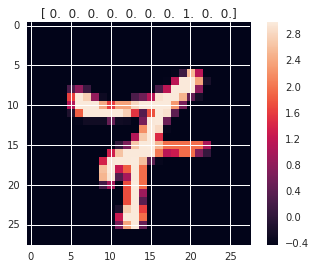

In [0]:
from matplotlib import pyplot as plt

x, y = sample(1)

plt.imshow(
    np.matrix(tf.reshape(x[0], (input_size, input_size)).numpy()), interpolation="nearest")
plt.colorbar()
plt.title(str(y[0].numpy()))
_ = plt.show()

### Train the model

We train for a  very small number of steps, because we only want to show that the model can train. Training should take 1.5 minutes, depending on the power of the machine on whici your kernel runs. 

  0:  4.288
 50:  1.616
 100:  0.585
 150:  0.477
 200:  0.452
 250:  0.220
 300:  0.295
 350:  0.173
 400:  0.259
 450:  0.189


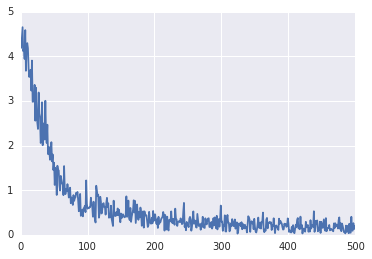

In [0]:
with tf.Graph().as_default(), tf.device('/gpu'):
  num_steps = 500

  params = train_utils.copy_dict(init_params)
  state = train_utils.copy_dict(init_state)
  
  lr = 1e-4
  losses = []
  
  vs = []
  train_utils.flatten_dict(params, vs)
  optimizer = tf.train.MomentumOptimizer(lr, 0.96)

  steps = list(range(num_steps))
  for i in steps:
    x, y = sample(64)
    
    dparams, l = dloss((x, y), params, state, hparams, tf.ones(()))
    
    grads = []
    train_utils.flatten_dict(dparams, grads)
    
    optimizer.apply_gradients(zip(grads, vs))

    losses.append(l)
    if num_steps < 10 or i % (num_steps // 10) == 0:
      print '% 3d: % 2.3f' % (i, l)

  _ = plt.plot(losses)

### Validate the model

Typically, one can easily reach 98% accuracy on MNIST. But since Resnet is so large, even with a small input, the "low" 90% validation accuracy is expected when training just 500 steps.

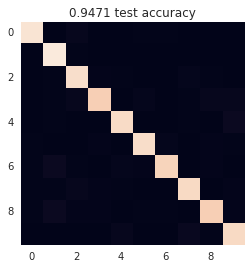

In [0]:
from sklearn import metrics

with tf.Graph().as_default(), tf.device('/gpu'):
  n = len(test[0])
  x, y = sample(n, test, False)
  logits = models.resnet_50(x, params, state, hparams)

  y = tf.argmax(y, axis=1).numpy()
  y_hat = tf.argmax(logits, axis=1).numpy()
  
  cmat = metrics.confusion_matrix(y_hat, y)
  cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]

  acc = np.sum((y == y_hat).astype('float')) / n

  plt.grid(False)
  plt.title('%s test accuracy' % acc)
  _ = plt.imshow(cmat, interpolation='nearest')